# Streamtracing and Topology Mapping in Gorgon

This is a guide for using the python tools developed for Gorgon. It covers:
* Using the field line tracer
* Using the connectivity tools

The modules containing these tools are in the `magnetosphere` module.

The guide assumes you are familiar with the Gorgon import. If not, see the 'Python Import for Gorgon Output' Notebook.

The field line tracer and connectivity tools have fortran code which needs to be compiled with `f2py`. This version contains precompiled code for Linux and Windows (x64), so it should work on `CX1` and Windows PCs.

The field line tracer and connectivity tools are parallelised using OpenMP.

Modules needed for this notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
latex = lambda x: '$\mathsf{'+x+'}$'
import sys
fdir = 'C:/Users/Lars/OneDrive - Imperial College London/Code/'
if fdir not in sys.path:
    sys.path.append(fdir)

## Loading Gorgon data

In [2]:
path_to_data = r'C:\Users\Lars\OneDrive - Imperial College London\Code\Shared\sample_data'

In [3]:
from magnetosphere.gorgon.gorgon_import import gorgon_sim

In [4]:
sim = gorgon_sim(path_to_data)
sim.import_timestep(-1)

# General Streamline Tracing

The module contains a general streamtracer which uses an RK4 integrator and trilinear interpolation.
It is written in FORTRAN, and is parallelised using OpenMP, but is accessed using a wrapper class in Python, `streamline_array`:

In [5]:
from magnetosphere.gorgon.streamline import streamline_array

To initalise, you need to specify the number of steps in each streamline, the integration step size.

To speed up computation, you can specify the direction of the streamline: 1 being forward, -1 being backward. If it's not specified, it defaults to 0, integrating in both directions and appending the resulting streamline to create one streamline

In [6]:
n_steps = 10000 # Number of steps available to the streamline solver
int_step = 0.1*sim.d[0] # Integration step size (1/10 of a grid cell)
v_streams = streamline_array(n_steps, int_step, direction=1)

As with all streamtracers, you need to specify seed points. Here, a 2D grid in the $y-z$ plane is used:

In [7]:
yi = np.linspace(-1, 1, 10)*10
zi = yi
yi, zi = np.meshgrid(yi, zi)
xi = 0*np.ones(yi.shape)

x0 = np.stack([xi.ravel(), yi.ravel(), zi.ravel()]).T # They need to be in nx by 3 array

Calculating the streamtracer is done through the `calc` method, where you specify the vector array and box spacng and centre:

In [8]:
v_streams.calc(x0, sim.arr['vvec'], sim.d, sim.xc)

Now they've been calculated, we can plot them using `matplotlib`:

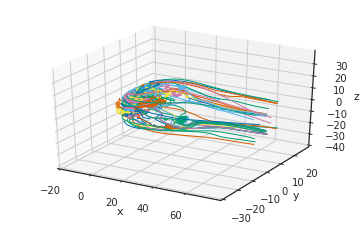

In [9]:
fig, ax = v_streams.plot3D()
sim.set_3D_axlim(ax) # This function sets the axis limits to that of the box
plt.show()

The `streamtracer` class has a lot more functionality, which will be shown in the next section, since this section has been added after I wrote that section.
The field line tracer is based on the streamtracer, but makes assumptions to tidy things up. It also has magnetic field specific functions such as determining the connectivity of a given field line.

# Field Line Tracing

This is a fieldline tracer writter in Fortran, but wrapped in Python. It is similar to paraview's streamline tracer in that it draws streamlines from vector field data, except python is much more powerful in how you can analyse those field lines.

We need to create a fieldlines object:

In [10]:
from magnetosphere.gorgon.fieldlines import fieldlines

In [11]:
n_steps = 10000 # Number of steps available to the streamline solver
int_step = 0.1*sim.d[0] # Integration step size (1/10 of a grid cell)
flines = fieldlines(n_steps, int_step)

Let's define some seed points for the fieldline tracer: these are the points the field lines will start from. They can be placed anywhere in the box: heres an example with points along the x axis at $y = 0$, $z = 10$

In [12]:
xi = sim.x
yi = np.zeros(xi.shape)
zi = 10*np.ones(xi.shape)

x0 = np.stack([xi, yi, zi]).T # They need to be in nx by 3 array

Calculate the field lines

In [13]:
sim.import_timestep(0, arr_names=['Bvec_c'])  # Load the data
flines.calc(x0, sim.arr['Bvec_c'], sim.d, sim.xc+0.5*sim.d) 
                            #0.5d offset because of cell centred variables

Now they've been calculated, we can plot them using `matplotlib`:

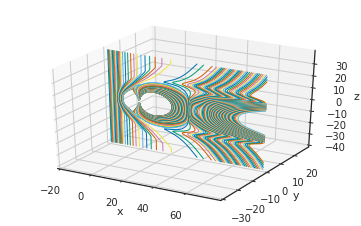

In [14]:
fig, ax = flines.plot3D()
sim.set_3D_axlim(ax) # This function sets the axis limits to that of the box
plt.show()

 ## Working with fieldlines
 
 ### Interpolating over other simulation variables
 
 We can interpolate other quantities in the simulation along the fieldlines, such as $\rho$.
 
 First we need to import them:

In [15]:
sim.import_timestep(-1, arr_names=['Bvec_c', 'rho1', 'jvec'])

This function interpolates for each value imported into `sim` along the each fieldline

In [16]:
for s in sim.arr:
    flines.interp(sim.x+0.5*sim.d[0], sim.y+0.5*sim.d[1], sim.z+0.5*sim.d[2], sim.arr[s], s)

You can use this function to give an overview of a particular field line.
On the left, it shows line plots of variables against fieldline length. The top shows the position of the fieldline, whereas the next ones show the values we have asked to interpolate for us.
On the right is a 3D plot of the field line in question.

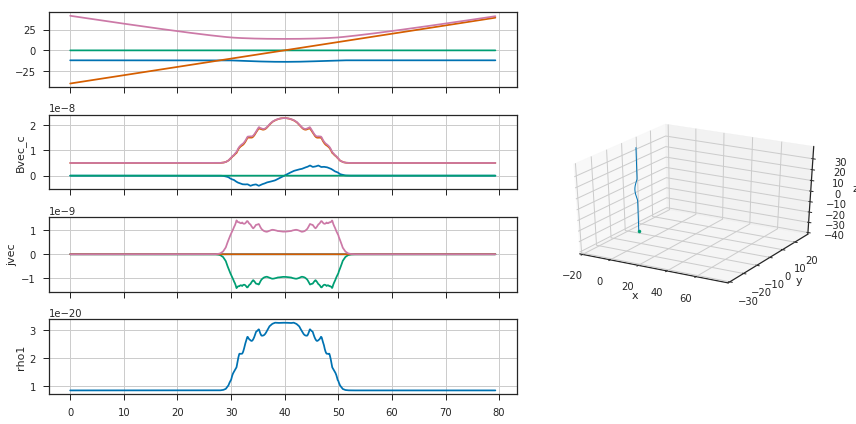

In [17]:
fieldline_no = 15
fig, ax1, ax2 = flines.plot_line(fieldline_no)
sim.set_3D_axlim(ax2)
plt.show()

### Finding Field Line Connectivity

To find the connectivity of each field line (i.e. whether it's an open, closed or solar wind fieldline), you can use the `calc_linkage` function:

In [18]:
flines.calc_linkage(sim)

This assigns a number to a given streamline depending on its connectivity:

| Link | Description | |
|------|:-----|:-------------|
| **1** | Solar Wind | both ends of field line goes out of domain |
| **2** | Closed | both ends end at inner boundary |
| **3** | North-Open | one end at outer boundary, the other at north pole |
| **4** | South-Open | one end at outer boundary, the other at south pole |


Additionally, there are extra integers used if the streamline tracer did not reach any boundary (usually due to an incomplete number of steps, or if the field becomes zero). These have the following values:

| Link | Description |
|------|:-----|
| **5** | One end reached the outer boundary |
| **6**  | One end reached the north pole boundary | 
| **7**  | One end reached the south pole boundary  | 
| **8** | Neither end reached any boundary | 

Unfortunately, there is no easy function to plot this in python.

So, we need to export it to Paraview.

## Writing fieldlines to file

Use the `write_vtp` function:

In [19]:
flines.write_vtp('fieldlines.vtp')

`fieldlines.vtp` can now be opened in Paraview. There you can colour your fieldlines by any of the interpolated values, as well as the connectivity (called 'link'). Heres an example of the field lines coloured by connectivity:

![alt text](paraview_field_lines.png "Logo Title Text 1")

**Note** in order to save space, the vtp writer does not write all the steps in each field line (in this case 10000 steps per fieldline). This may cause the field line to look under-resolved in areas of high curvature. To fix this, play around with the optional argument `pts_per_step` in `write_vtp`.

## Filtering out streamlines

This function is for if you want to reduce the number of field lines you want to keep.

Say you only want open field lines:

In [20]:
flines.filter(flines.cell_data['link'] == 1)

This deletes all the fieldlines where `flines.cell_data['link'] == 1` returns false.

## Dealing with multiple timesteps

Using a `for` loop, we can apply the same code to multiple timesteps, exporting the calculated field lines each timestep.

In [21]:
# Create fieldline object
flines = fieldlines(10000, 0.1*sim.d[0])

# Choose your seed points
xi = sim.x
yi = np.zeros(xi.shape)
zi = 10*np.ones(xi.shape)

x0 = np.stack([xi, yi, zi]).T # They need to be in nx by 3 array

# Choose which variables we want to import
var_list = ['rho', 'vvec', 'Bvec_c']

# Loop over every timestep
for it, ct in enumerate(sim.times):
    # Import the current timestep
    sim.import_timestep(it, arr_names=var_list)
    
    # Calculate the fieldlines
    flines.calc(x0, sim.arr['Bvec_c'], sim.d, sim.xc+0.5*sim.d)
    
    # Interpolate over the other variables
    for s in sim.arr:
        flines.interp(sim.x+0.5*sim.d[0], sim.y+0.5*sim.d[1], sim.z+0.5*sim.d[2], sim.arr[s], s)
    
    # Calculate connectivity
    flines.calc_linkage(sim)
    
    # Write to file
    flines.write_vtp(sim.index+'_fieldlines-'+ct+'.vtp')
    
    flines.reset() # Resets the fieldline calculation so it can be done in the next loop iteration

This will calculate the field lines for every timestep found in the data directory, interpolate over the other variables, calculate the connectivity, and write to file.

# Using the Connectivity Functions

This is for if you want to see where a given position in the simulation is connected to by a magnetic fieldline.
This is an optimised version of the fieldline tracer: it will not give you the fieldline position as a function of fieldline length. This is useful for if you want to see how different regions of the simulation are connected.

The module only contains one function: `calc_connectivity`. 

In [22]:
from magnetosphere.gorgon.connectivity import calc_connectivity

`calc_connectivity` takes a given a set of points and traces the magnetic field in both directions  until it either hits a boundary, or it reaches the inner boundary.

Let's import some data too:

In [23]:
sim = gorgon_sim(path_to_data)
sim.import_timestep(-1, arr_names=['Bvec_c', 'rho1']) 
    #-1 imports the last timestep

Again, we need to define seed points. Say we want to see how points in the $x-y$ plane are connected to the magnetosphere:

In [24]:
xi, yi = np.meshgrid(sim.x, sim.y)
xi = xi.ravel()
yi = yi.ravel()
zi = np.zeros(xi.shape)

x0 = np.stack([xi, yi, zi]).T+0.5*sim.d # calc_end_points takes a N x 3 array

Run the function:

In [25]:
link = calc_connectivity(x0, sim.arr['Bvec_c'], sim.d, sim.xc)

In [26]:
link_grid = link.reshape(len(sim.y), len(sim.x))

Plotting the connectivity, you can see how each point is connected

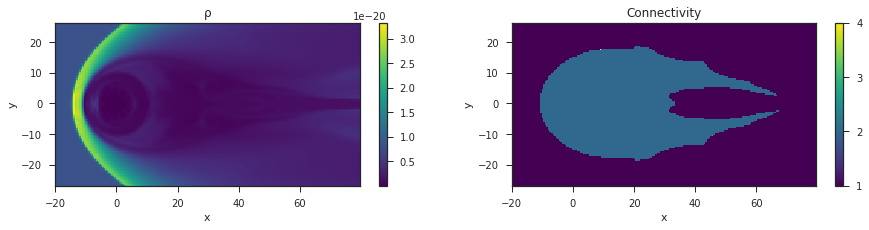

In [27]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15, 3))
iz = int(0.5*len(sim.z))
p = ax[0].pcolormesh(sim.x, sim.y, sim.arr['rho1'][:, :, iz].T)
plt.colorbar(p, ax=ax[0])
p = ax[1].pcolormesh(sim.x, sim.y, link_grid)
plt.colorbar(p, ax=ax[1], ticks=np.unique(link_grid))
ax[0].set(ylabel='y', xlabel='x', title=latex(r'\rho'), aspect=1)
ax[1].set(ylabel='y', xlabel='x', title='Connectivity', aspect=1)
plt.show()

The right figure shows the connectivity of $x-y$ slice, with the same values as before

## Saving to File

There is a scalar `pvti` writer in `gorgon_sim`, which will allow you to write out the link as a `pvti` file. Let's use the connectivity tracer on a 3D grid:

In [28]:
x = np.arange(0, 40, sim.d[0])
y = np.arange(-20, 20, sim.d[0])
z = np.arange(-10, 10, sim.d[0])

Y, X, Z = np.meshgrid(y, x, z)

x0 = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

Doing it for the whole grid is quite slow, so I've only done it for a subsection

In [29]:
link = calc_connectivity(x0, sim.arr['Bvec_c'], sim.d, sim.xc)

In [30]:
link_grid = link.reshape(X.shape)

Write to file using:

In [31]:
sim.write_vti_scalar(link_grid, x, y, z, 'link')

This creates a `vti` file you can open in Paraview. Here's an example output:
![alt text](paraview_conn_tracer.png "Logo Title Text 1")